## Phase 1: Data Loading & Initial EDA

In [1]:
import sys
sys.path.append('../src')  # Add source directory to path

### loding Required Libraries

In [2]:
from data_loading.wesad_loader import WESADLoader
from data_loading.physionet_loader import PhysioNetLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Dataset Initialization

In [3]:
wesad_path = '../raw_data/WESAD'
physionet_path = '../raw_data/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data'

In [4]:
wesad_loader = WESADLoader(wesad_path)
physionet_loader = PhysioNetLoader(physionet_path)

### WESAD Dataset Exploration

In [5]:
import pickle
with open('../raw_data/WESAD/S2/S2.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')
print(data.keys())  # Should show dict keys

dict_keys(['signal', 'label', 'subject'])


In [6]:
print(type(wesad_loader.load_subject(2)))  # Should be pd.DataFrame
print(wesad_loader.load_subject(2).columns)

182736 ACC samples exceed 3.5g


<class 'pandas.core.frame.DataFrame'>


182736 ACC samples exceed 3.5g


Index(['bvp', 'acc_x', 'acc_y', 'acc_z', 'label', 'subject_id',
       'sampling_rate'],
      dtype='object')


In [6]:
# Modify the WESAD loading cell to handle validation warnings
try:
    wesad_subject = wesad_loader.load_subject(2)
except ValueError as e:
    print(f"Loading failed: {str(e)}")
    wesad_subject = None

if wesad_subject is not None:
    # Display basic information
    print(f"Loaded subject {wesad_subject['subject_id'].iloc[0]} from WESAD")
    print(f"  - Total samples: {len(wesad_subject)}")
    print(f"  - Sampling rate: {wesad_subject['sampling_rate'].iloc[0]} Hz")
else:
    print("Could not load WESAD subject data")


182736 ACC samples exceed 3.5g


Loaded subject 2 from WESAD
  - Total samples: 182738
  - Sampling rate: 30 Hz


In [7]:
# In your notebook
print(f"WESAD data columns: {wesad_subject.columns}")
print(f"Subject ID: {wesad_subject['subject_id'].unique()}")
print(f"Label distribution:\n{wesad_subject['label'].value_counts()}")

WESAD data columns: Index(['bvp', 'acc_x', 'acc_y', 'acc_z', 'label', 'subject_id',
       'sampling_rate'],
      dtype='object')
Subject ID: [2]
Label distribution:
label
0.0    137746
1.0     24267
2.0     13046
3.0      7679
Name: count, dtype: int64


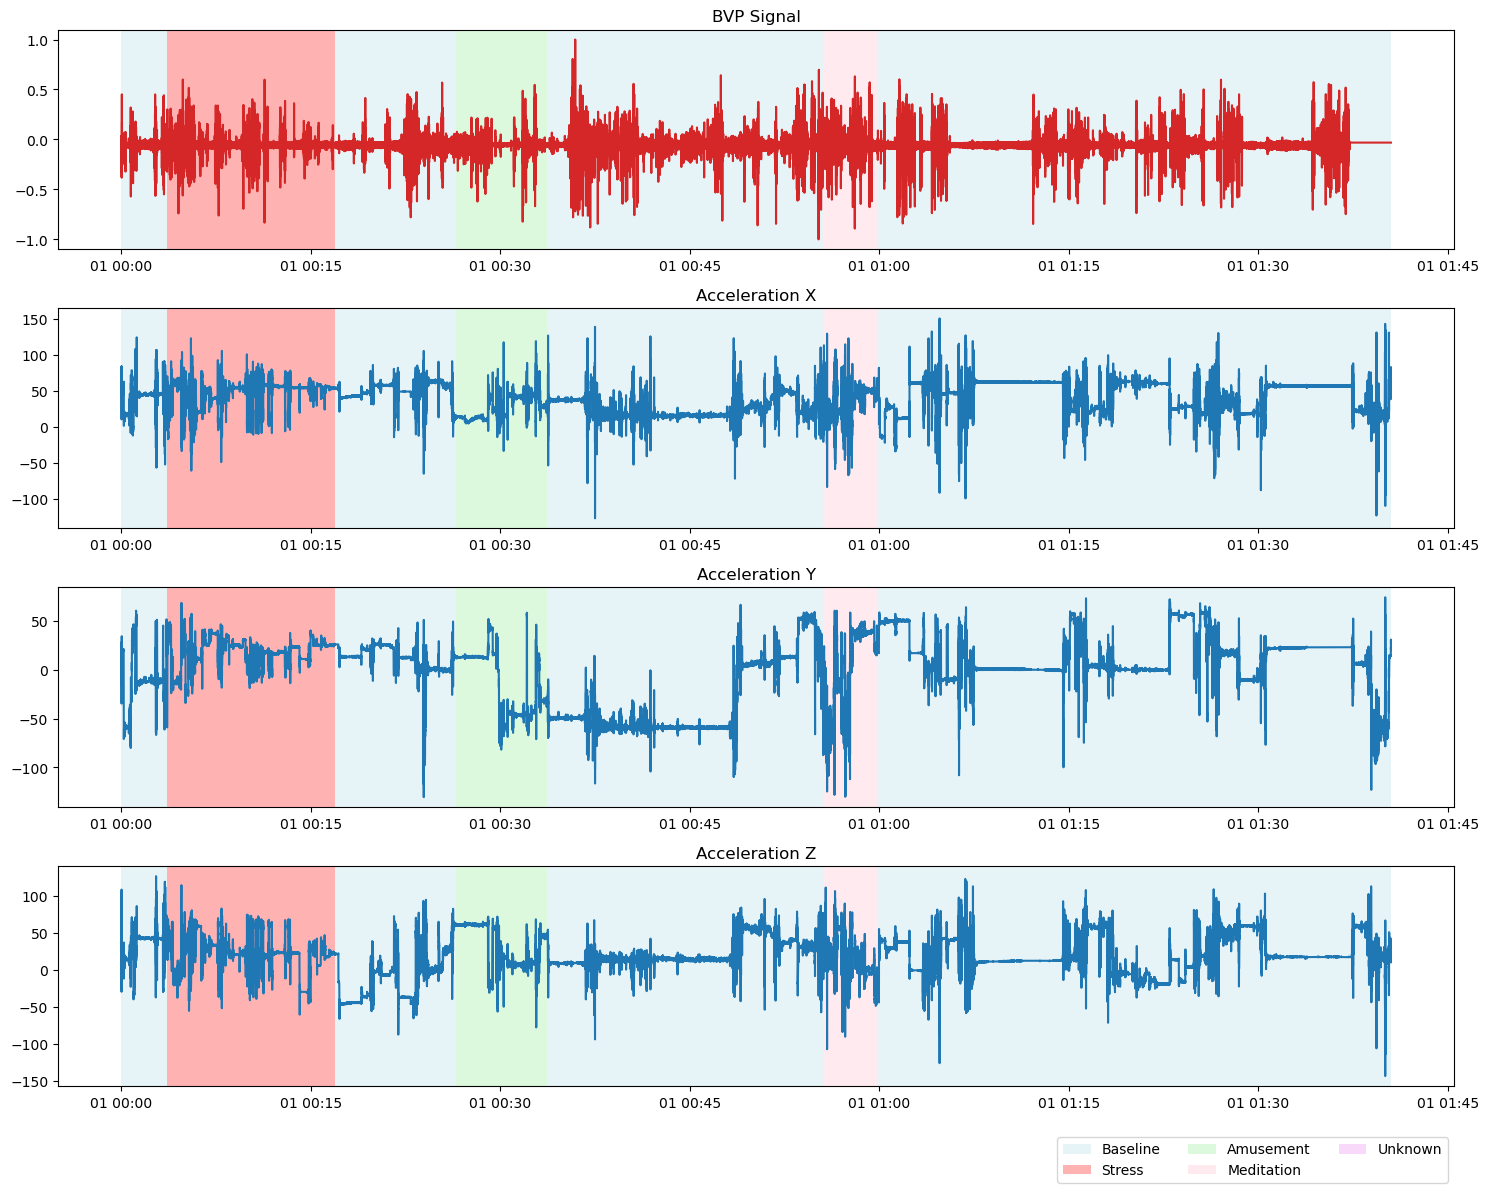

In [8]:
def plot_wesad_signals_with_labels(df):
    """Plot physiological signals with label-colored background regions"""
    fig, ax = plt.subplots(4, 1, figsize=(15, 12))
    
    # Define label-color mapping
    label_colors = {
        0: 'lightblue',   # Baseline
        1: 'red',         # Stress
        2: 'lightgreen',  # Amusement
        3: 'pink',        # Meditation
        4: 'violet',      # Unknown (invalid)
        6: 'violet',      
        7: 'violet'       
    }
    
    # Plot signals
    ax[0].plot(df['bvp'], color='tab:red')
    ax[0].set_title('BVP Signal')
    
    for i, axis in enumerate(['x', 'y', 'z']):
        ax[i+1].plot(df[f'acc_{axis}'], color='tab:blue')
        ax[i+1].set_title(f'Acceleration {axis.upper()}')
    
    # Create label regions
    label_changes = df['label'].ne(df['label'].shift()).cumsum()
    
    for _, group in df.groupby(label_changes):
        label = group['label'].iloc[0]
        start_time = group.index[0]
        end_time = group.index[-1]
        
        for a in ax:
            a.axvspan(start_time, end_time, 
                      facecolor=label_colors.get(label, 'violet'),
                      alpha=0.3)
    
    # Create unified legend
    legend_labels = {
        'Baseline': 'lightblue',
        'Stress': 'red',
        'Amusement': 'lightgreen',
        'Meditation': 'pink',
        'Unknown': 'violet'
    }
    
    patches = [plt.Rectangle((0,0),1,1, fc=color, alpha=0.3) 
               for color in legend_labels.values()]
    
    ax[-1].legend(patches, legend_labels.keys(),
                 loc='upper right', ncol=3,
                 bbox_to_anchor=(1, -0.2))
    
    plt.tight_layout()
    plt.show()  # Single plot display

plot_wesad_signals_with_labels(wesad_subject)


In [9]:
# After loading
print(f"Resampled shapes:")
print(f"BVP: {len(wesad_subject['bvp'])}")
print(f"ACC: {len(wesad_subject['acc_x'])}")
print(f"Labels: {len(wesad_subject['label'])}")

Resampled shapes:
BVP: 182738
ACC: 182738
Labels: 182738


#### Signal Visualization

In [10]:
def plot_wesad_signals(df):
    fig, ax = plt.subplots(4, 1, figsize=(15, 10))
    
    # BVP Plot
    ax[0].plot(df['bvp'], color='tab:red')
    ax[0].set_title('BVP Signal')
    
    # ACC Plots
    for i, axis in enumerate(['x', 'y', 'z']):
        ax[i+1].plot(df[f'acc_{axis}'], color='tab:blue')
        ax[i+1].set_title(f'Acceleration {axis.upper()}')
    
    plt.tight_layout()
    return fig

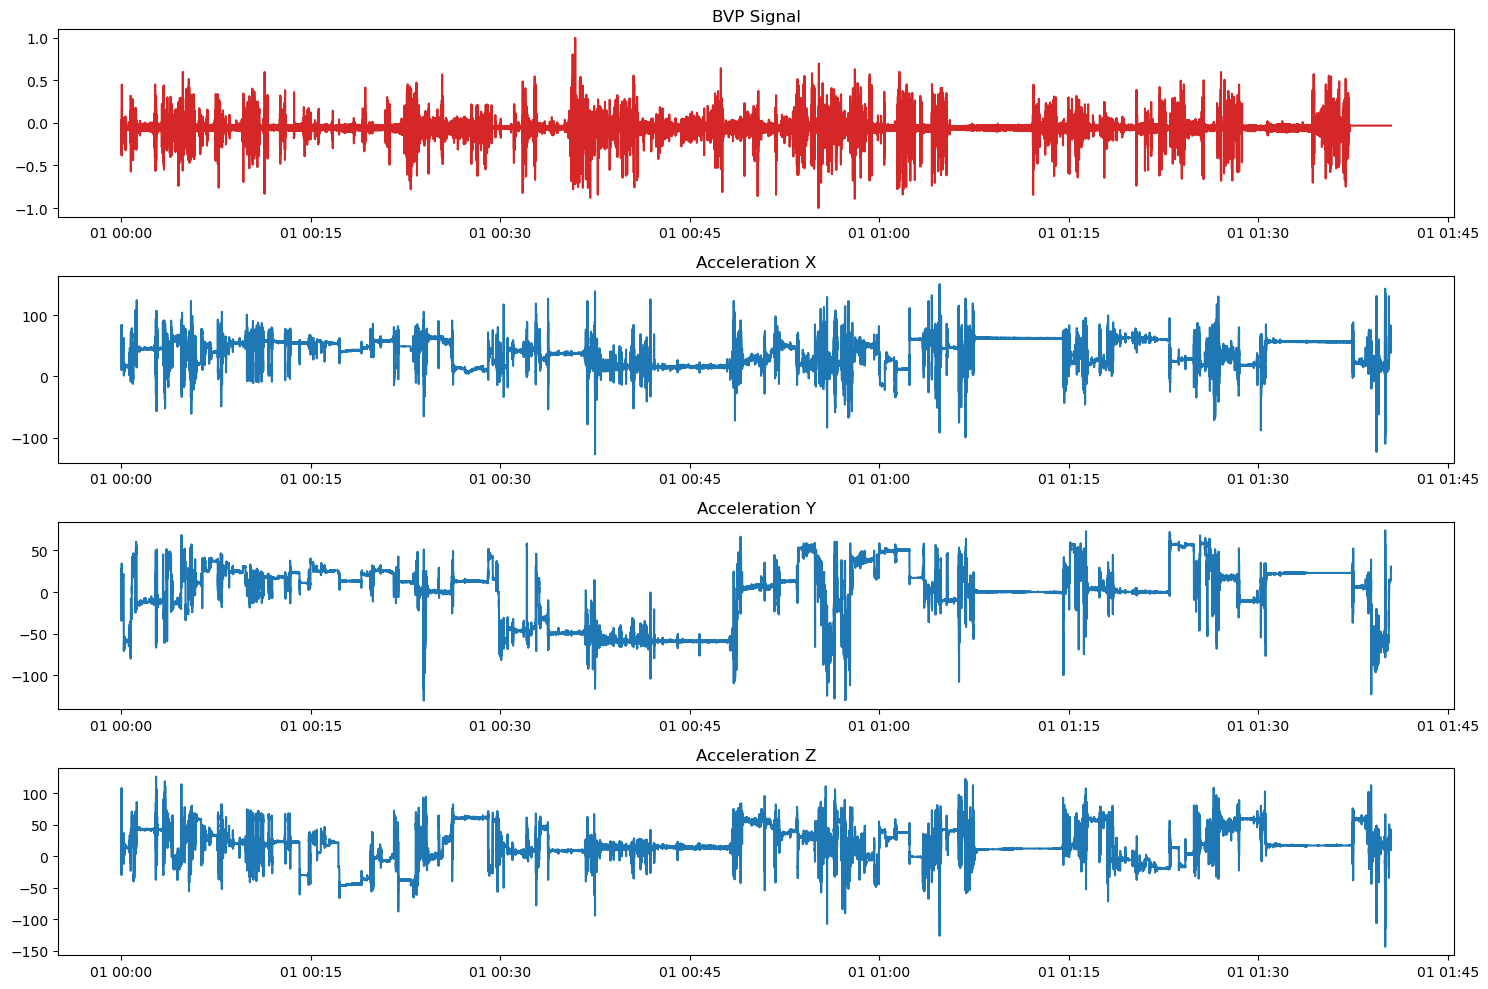

In [11]:
plot_wesad_signals(wesad_subject)
plt.show()

### PhysioNet Dataset Exploration

In [7]:
def debug_sensor(loader, sensor):
    path = loader.data_path/'S1'/'Midterm 1'/f"{sensor.upper()}.csv"
    print(f"\n{sensor.upper()} data:")
    print("Path exists:", path.exists())
    if path.exists():
        with open(path) as f:
            print("First 3 lines:", [next(f).strip() for _ in range(3)])
            
debug_sensor(physionet_loader, 'bvp')
debug_sensor(physionet_loader, 'acc')
debug_sensor(physionet_loader, 'hr')


BVP data:
Path exists: True
First 3 lines: ['1539435366.00', '64.000000', '-0.00']

ACC data:
Path exists: True
First 3 lines: ['1539435366.000000, 1539435366.000000, 1539435366.000000', '32.000000, 32.000000, 32.000000', '-3,-62,12']

HR data:
Path exists: True
First 3 lines: ['1539435376.000000', '1.000000', '84.00']


In [8]:
df = physionet_loader.load_subject(1, "Midterm 1")
print(df.columns.tolist())  

['bvp', 'acc_x', 'acc_y', 'acc_z', 'eda', 'temp', 'hr', 'event', 'subject_id', 'session', 'sampling_rate']


In [13]:
# Add quality assessment before loading
try:
    physionet_subject = physionet_loader.load_subject(1, 'Midterm 1')
except Exception as e:
    print(f"Critical error: {str(e)}")
    # Load ACC-only data for analysis
    acc_data = physionet_loader.load_acc_only(1, 'Midterm 1')
    if acc_data is not None:
        print(f"Loaded ACC data with {len(acc_data)} samples")

if physionet_subject is not None:
    print(f"Loaded subject {physionet_subject['subject_id']}")
    print(f"Samples: {len(physionet_subject)}")
    print(f"Columns: {physionet_subject.columns.tolist()}")
else:
    print("Failed to load PhysioNet data")

Loaded subject timestamp
2018-10-13 12:56:06+00:00           1
2018-10-13 12:56:06.033000+00:00    1
2018-10-13 12:56:06.066000+00:00    1
2018-10-13 12:56:06.099000+00:00    1
2018-10-13 12:56:06.132000+00:00    1
                                   ..
2018-10-13 16:02:24.090000+00:00    1
2018-10-13 16:02:24.123000+00:00    1
2018-10-13 16:02:24.156000+00:00    1
2018-10-13 16:02:24.189000+00:00    1
2018-10-13 16:02:24.222000+00:00    1
Freq: 33L, Name: subject_id, Length: 338735, dtype: int64
Samples: 338735
Columns: ['bvp', 'acc_x', 'acc_y', 'acc_z', 'eda', 'temp', 'hr', 'event', 'subject_id', 'session', 'sampling_rate']


In [14]:
print("Event markers placed at:", physionet_subject[physionet_subject['event'] == 1].index)

Event markers placed at: DatetimeIndex(['2018-10-13 15:53:17.313000+00:00',
               '2018-10-13 15:53:17.346000+00:00',
               '2018-10-13 15:53:17.379000+00:00',
               '2018-10-13 15:53:17.412000+00:00',
               '2018-10-13 15:53:17.445000+00:00',
               '2018-10-13 15:53:17.478000+00:00',
               '2018-10-13 15:53:17.511000+00:00',
               '2018-10-13 15:53:17.544000+00:00',
               '2018-10-13 15:53:17.577000+00:00',
               '2018-10-13 15:53:17.610000+00:00',
               ...
               '2018-10-13 16:02:23.925000+00:00',
               '2018-10-13 16:02:23.958000+00:00',
               '2018-10-13 16:02:23.991000+00:00',
               '2018-10-13 16:02:24.024000+00:00',
               '2018-10-13 16:02:24.057000+00:00',
               '2018-10-13 16:02:24.090000+00:00',
               '2018-10-13 16:02:24.123000+00:00',
               '2018-10-13 16:02:24.156000+00:00',
               '2018-10-13 16:02:24.18

In [15]:
# After loading data:
print("Event markers:", physionet_subject['event'].sum())
print("ACC stats:", physionet_subject[['acc_x','acc_y','acc_z']].describe())

# Check temporal alignment
print("\nIndex alignment check:")
print("Start:", physionet_subject.index[0])
print("End:", physionet_subject.index[-1])
print("Sample rate:", 1e3/(physionet_subject.index[1] - physionet_subject.index[0]).microseconds/1e3)

Event markers: 9103
ACC stats:                acc_x          acc_y          acc_z
count  338735.000000  338735.000000  338735.000000
mean      -26.479558      10.665845      13.241265
std        26.976628      36.097565      34.867540
min      -128.000000    -128.000000    -128.000000
25%       -48.000000      -6.000000      -8.000000
50%       -31.000000       5.000000      11.000000
75%        -3.000000      34.000000      49.000000
max       127.000000     127.000000     127.000000

Index alignment check:
Start: 2018-10-13 12:56:06+00:00
End: 2018-10-13 16:02:24.222000+00:00
Sample rate: 3.0303030303030302e-05


In [16]:
print("BVP samples:", len(physionet_subject['bvp']))  # Should be >700k
print("ACC samples:", len(physionet_subject['acc_x']))   # Should be >350k

BVP samples: 338735
ACC samples: 338735


In [17]:
# After loading
print("Merged index range:", physionet_subject.index[[0, -1]])  # Should show full duration
print("Non-NA counts:", physionet_subject.count())  # All columns should have same count

Merged index range: DatetimeIndex(['2018-10-13 12:56:06+00:00', '2018-10-13 16:02:24.222000+00:00'], dtype='datetime64[ns, UTC]', name='timestamp', freq=None)
Non-NA counts: bvp              338735
acc_x            338735
acc_y            338735
acc_z            338735
eda              338735
temp             338735
hr               338735
event            338735
subject_id       338735
session          338735
sampling_rate    338735
dtype: int64


In [18]:
print("IBI index monotonic:", physionet_subject['hr'].index.is_monotonic_increasing)

IBI index monotonic: True


In [19]:
from pathlib import Path
# Test loading individual sensors
test_bvp = physionet_loader._load_sensor_data(
    Path(physionet_path)/'S1/Midterm 1/BVP.csv'
)
print(f"BVP data loaded: {len(test_bvp[2])} samples")

BVP data loaded: 715407 samples


In [20]:
print("PhysioNet columns:", physionet_subject.columns.tolist())

PhysioNet columns: ['bvp', 'acc_x', 'acc_y', 'acc_z', 'eda', 'temp', 'hr', 'event', 'subject_id', 'session', 'sampling_rate']


In [21]:
print(f"ACC shape: {physionet_subject[['acc_x','acc_y','acc_z']].shape}")

ACC shape: (338735, 3)


In [22]:
# Display basic information
print(f"\nLoaded subject {physionet_subject['subject_id']} from PhysioNet")
print(f"  - Total samples: {len(physionet_subject)}")
print(f"  - Sampling rate: {physionet_subject['sampling_rate']} Hz")


Loaded subject timestamp
2018-10-13 12:56:06+00:00           1
2018-10-13 12:56:06.033000+00:00    1
2018-10-13 12:56:06.066000+00:00    1
2018-10-13 12:56:06.099000+00:00    1
2018-10-13 12:56:06.132000+00:00    1
                                   ..
2018-10-13 16:02:24.090000+00:00    1
2018-10-13 16:02:24.123000+00:00    1
2018-10-13 16:02:24.156000+00:00    1
2018-10-13 16:02:24.189000+00:00    1
2018-10-13 16:02:24.222000+00:00    1
Freq: 33L, Name: subject_id, Length: 338735, dtype: int64 from PhysioNet
  - Total samples: 338735
  - Sampling rate: timestamp
2018-10-13 12:56:06+00:00           30
2018-10-13 12:56:06.033000+00:00    30
2018-10-13 12:56:06.066000+00:00    30
2018-10-13 12:56:06.099000+00:00    30
2018-10-13 12:56:06.132000+00:00    30
                                    ..
2018-10-13 16:02:24.090000+00:00    30
2018-10-13 16:02:24.123000+00:00    30
2018-10-13 16:02:24.156000+00:00    30
2018-10-13 16:02:24.189000+00:00    30
2018-10-13 16:02:24.222000+00:00    30

In [23]:
physionet_subject['event'].value_counts()

event
0    329632
1      9103
Name: count, dtype: int64

In [24]:
# Dataset structure inspection
print("\nPhysioNet data columns:", physionet_subject.columns.tolist())
print(f"Subject ID: {physionet_subject['subject_id'].unique()}")
print(f"Label distribution:\n{physionet_subject['event'].value_counts()}")


PhysioNet data columns: ['bvp', 'acc_x', 'acc_y', 'acc_z', 'eda', 'temp', 'hr', 'event', 'subject_id', 'session', 'sampling_rate']
Subject ID: [1]
Label distribution:
event
0    329632
1      9103
Name: count, dtype: int64


In [25]:
# In your PhysioNet analysis cell (cell In[26]):
# Change from:
print(f"Label distribution:\n{physionet_subject['event'].value_counts()}")


Label distribution:
event
0    329632
1      9103
Name: count, dtype: int64


#### PhysioNet Signal Visualization

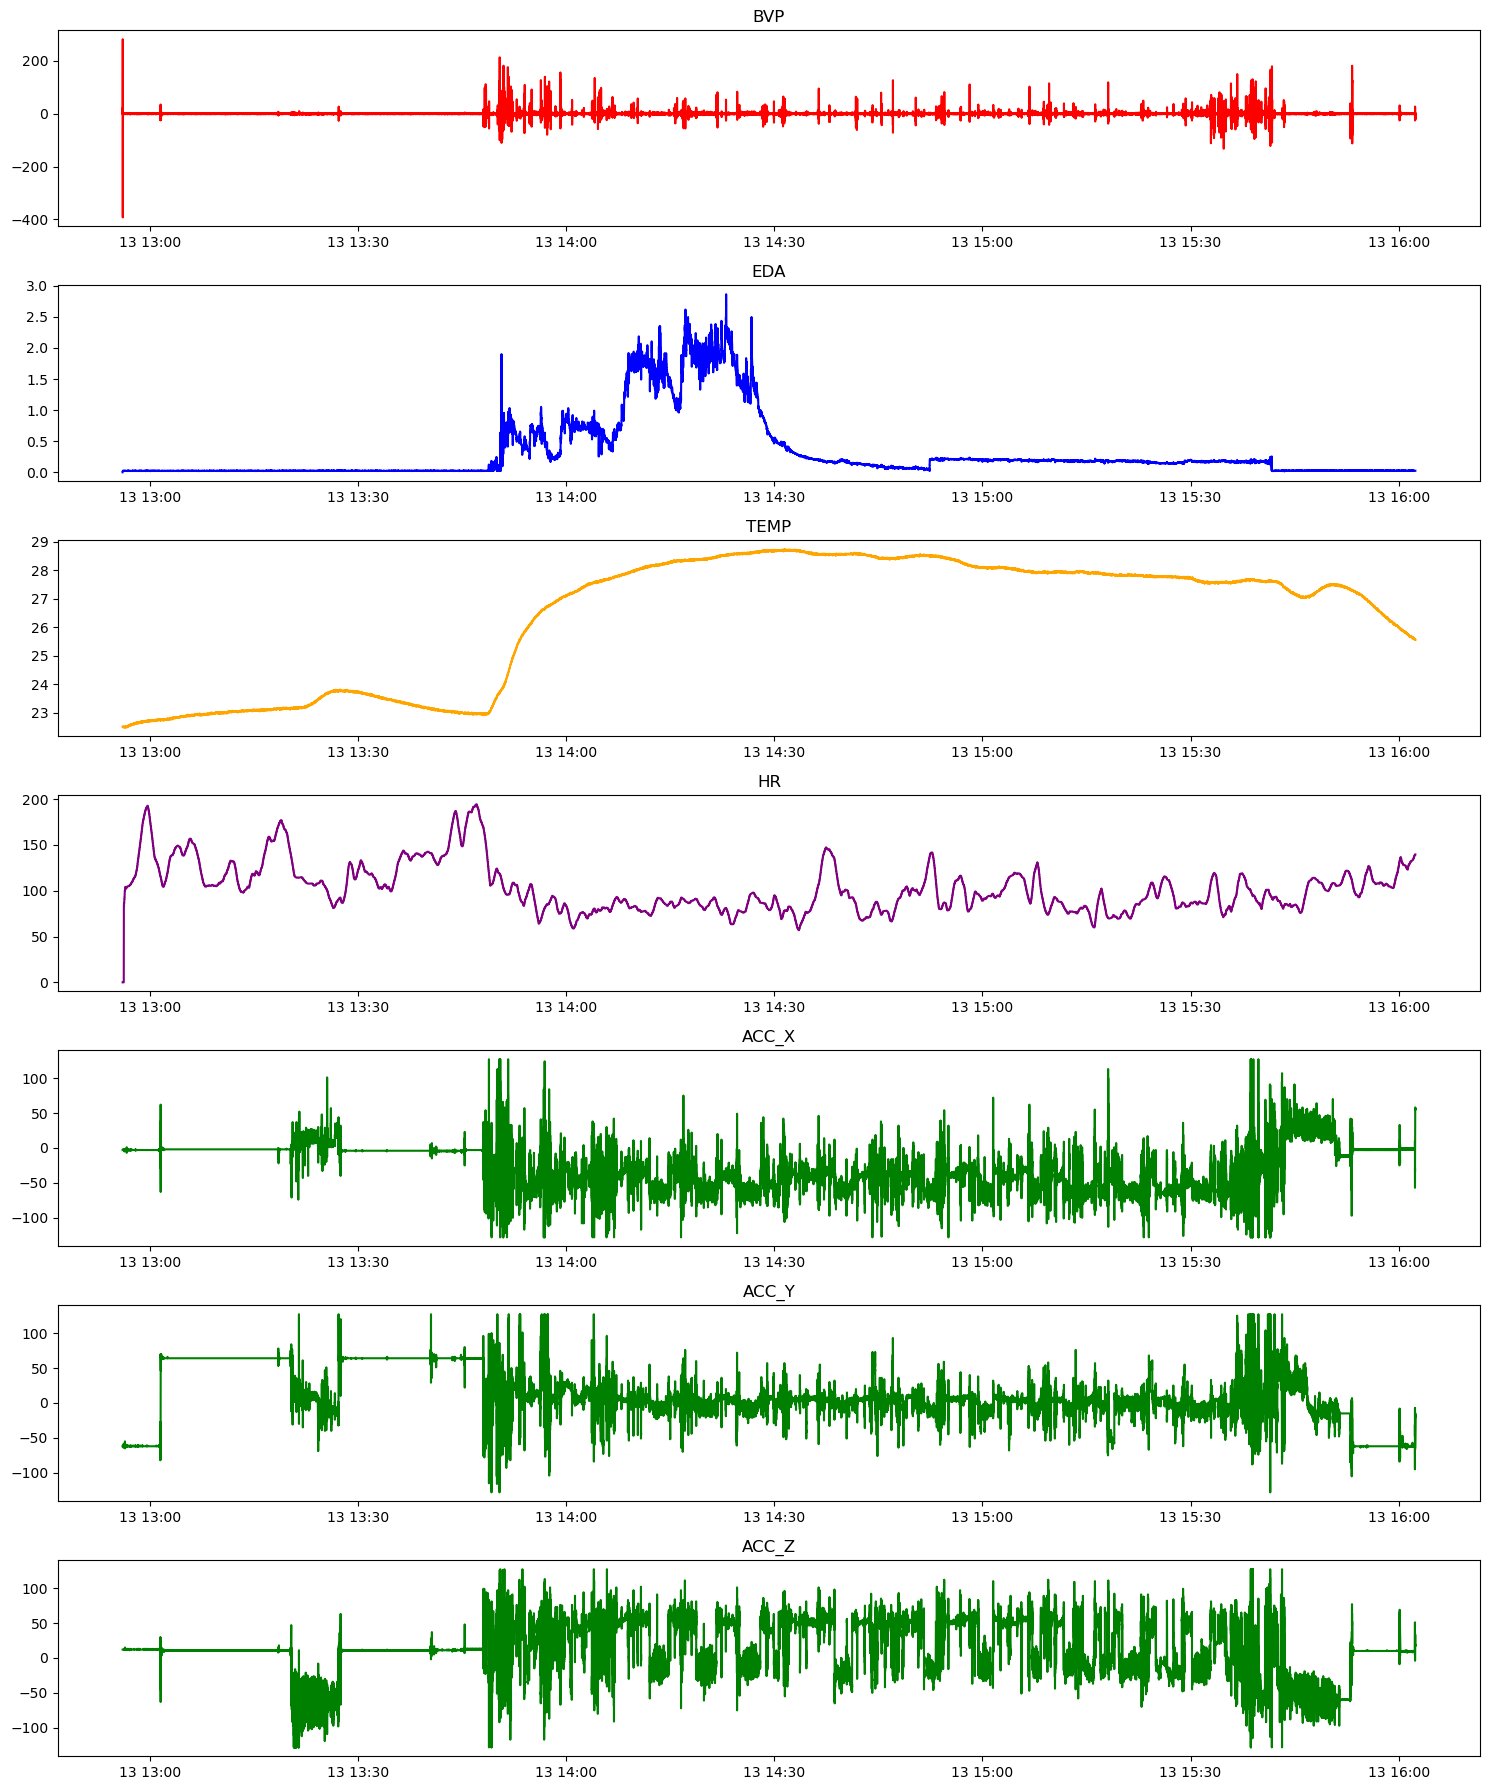

In [26]:
# New visualization for full dataset
def plot_physionet_full(df):
    fig, ax = plt.subplots(7, 1, figsize=(15, 18))
    sensors = [
        ('bvp', 'red'), ('eda', 'blue'), ('temp', 'orange'),
        ('hr', 'purple'), ('acc_x', 'green'), 
        ('acc_y', 'green'), ('acc_z', 'green')
    ]
    for i, (col, color) in enumerate(sensors):
        ax[i].plot(df[col], color=color)
        ax[i].set_title(col.upper())
    plt.tight_layout()
    return fig

plot_physionet_full(physionet_subject)
plt.show()

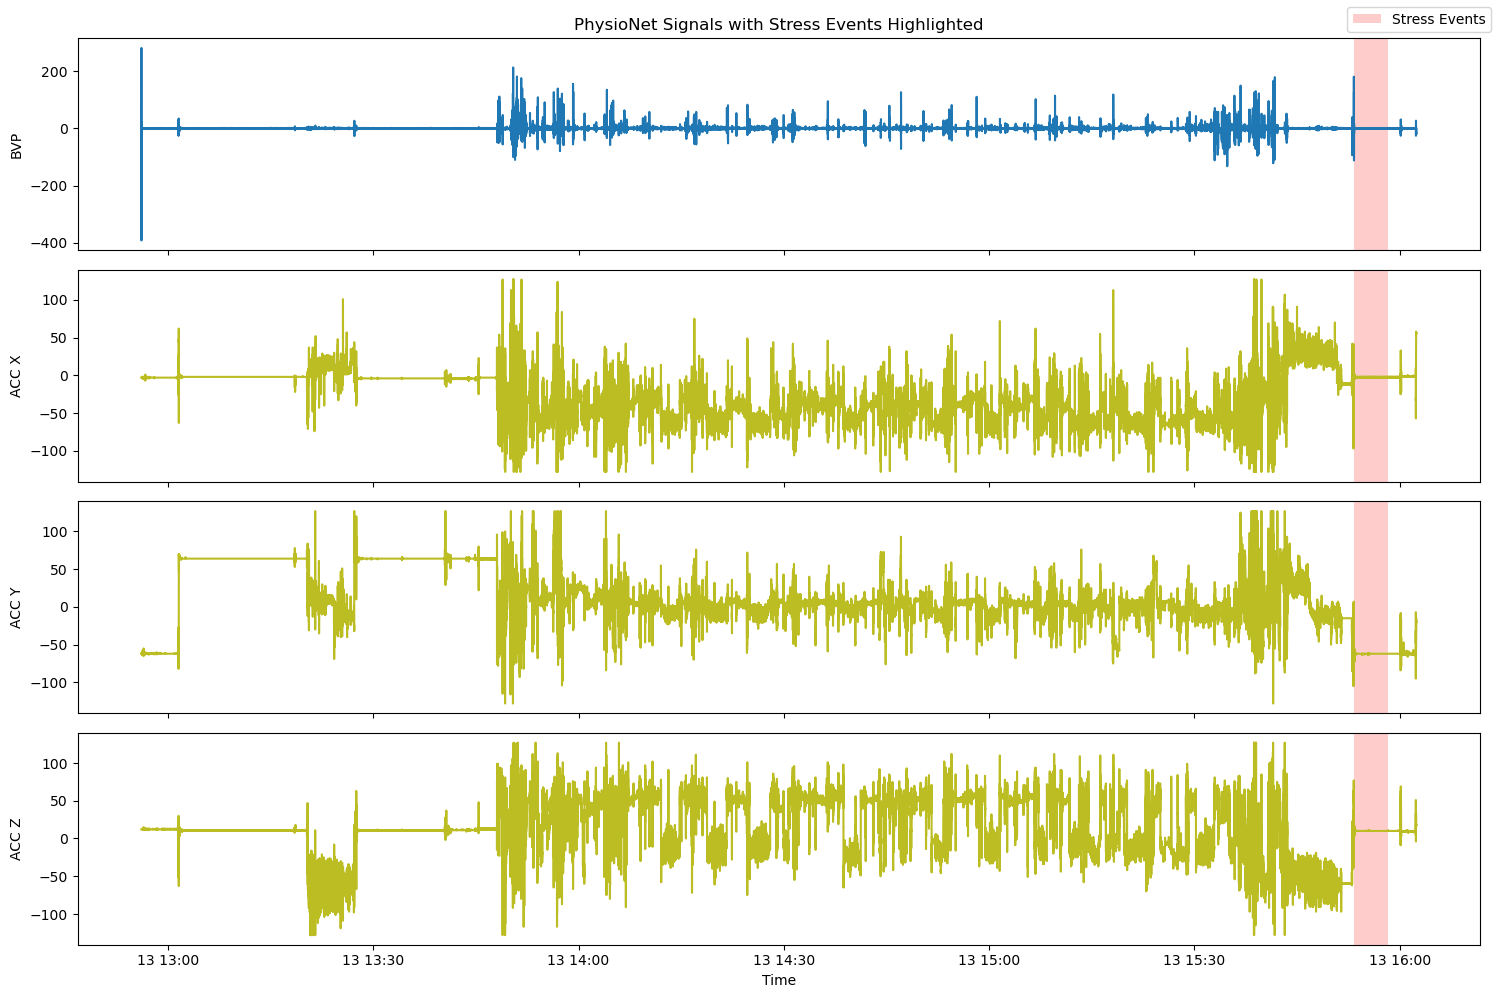

In [27]:
def plot_physionet_with_events(df):
    """Plot physiological signals with stress event regions highlighted"""
    fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
    
    # Find stress event periods using index directly
    stress_events = df[df['event'] == 1]
    if not stress_events.empty:
        # Create groups of continuous events
        stress_periods = stress_events.index.to_series().diff().gt('1s').cumsum()
        # Get start/end times from index
        event_ranges = stress_events.groupby(stress_periods).apply(
            lambda grp: (grp.index[0], grp.index[-1])
        ).tolist()
    
    # Plot signals
    ax[0].plot(df['bvp'], color='tab:blue', label='BVP')
    ax[1].plot(df['acc_x'], color='tab:olive', label='X')
    ax[2].plot(df['acc_y'], color='tab:olive', label='Y') 
    ax[3].plot(df['acc_z'], color='tab:olive', label='Z')
    
    # Add red shading if events exist
    if not stress_events.empty:
        for start, end in event_ranges:
            for axis in ax:
                axis.axvspan(start, end, color='red', alpha=0.2, lw=0)
    
    # Configure plot elements
    ax[0].set_title("PhysioNet Signals with Stress Events Highlighted")
    ax[-1].set_xlabel("Time")
    for i, label in enumerate(['BVP', 'ACC X', 'ACC Y', 'ACC Z']):
        ax[i].set_ylabel(label)
    
    # Create unified legend
    handles = [plt.Rectangle((0,0),1,1, fc='red', alpha=0.2)]
    labels = ['Stress Events']
    fig.legend(handles, labels, loc='upper right')
    
    plt.tight_layout()
    return fig

plot_physionet_with_events(physionet_subject)
plt.show()


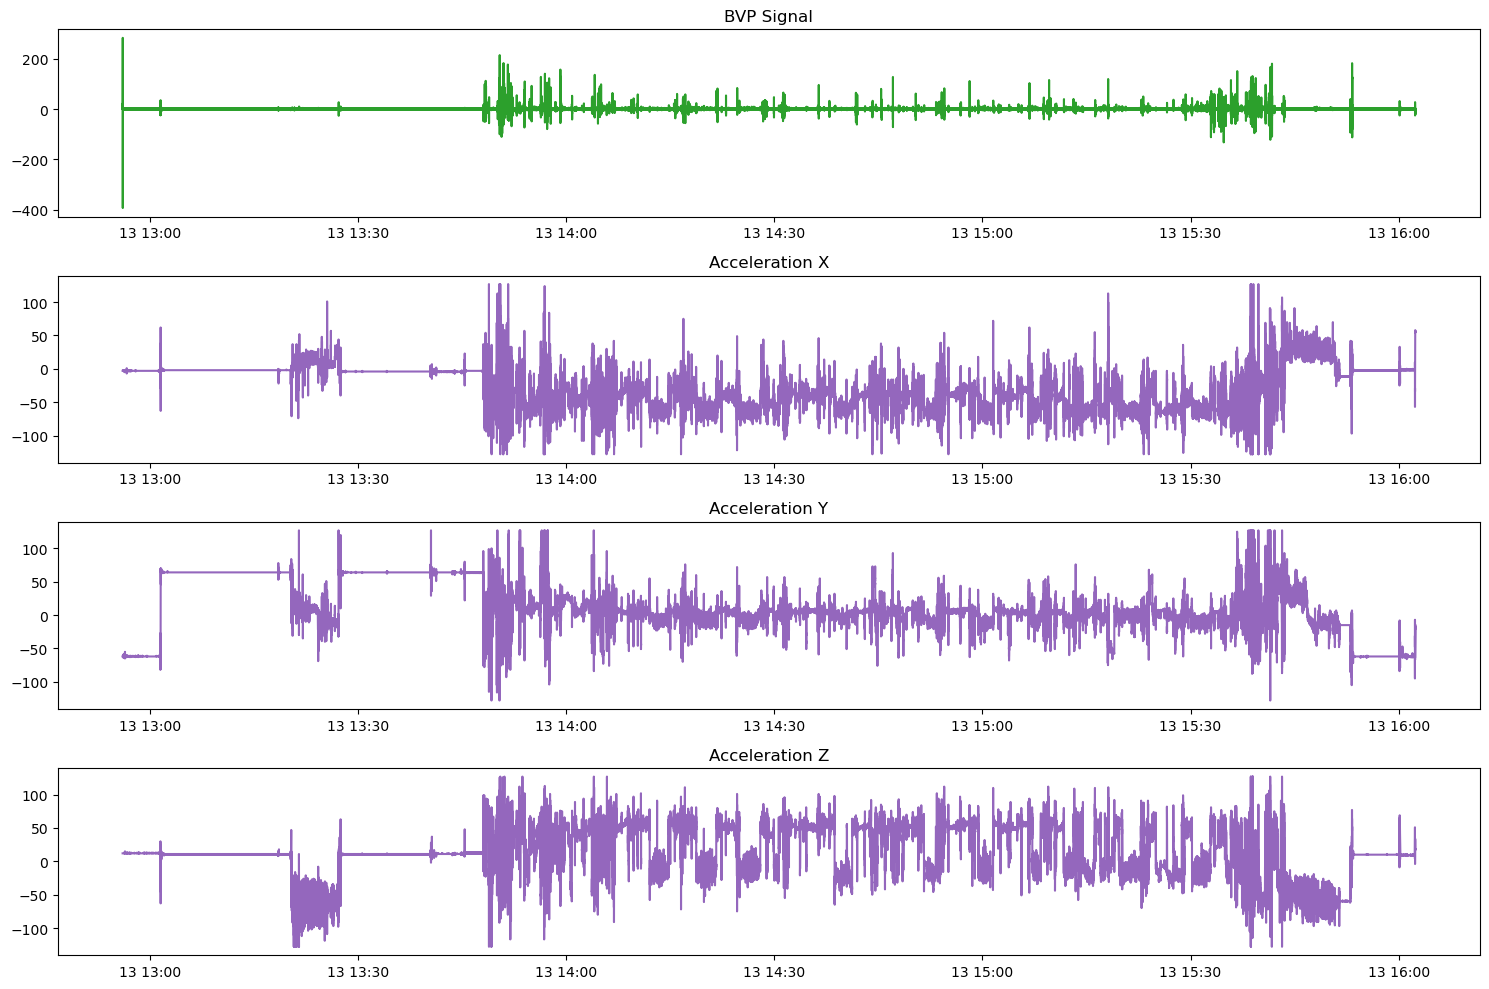

In [28]:
def plot_physionet_signals(df):
    fig, ax = plt.subplots(4, 1, figsize=(15, 10))
    
    # BVP Plot
    ax[0].plot(df['bvp'], color='tab:green')
    ax[0].set_title('BVP Signal')
    
    # ACC Plots
    for i, axis in enumerate(['x', 'y', 'z']):
        ax[i+1].plot(df[f'acc_{axis}'], color='tab:purple')
        ax[i+1].set_title(f'Acceleration {axis.upper()}')
    
    plt.tight_layout()
    return fig

plot_physionet_signals(physionet_subject)
plt.show()

#### Cross-Dataset Comparison

In [29]:
import numpy as np
def compare_signal_stats(*datasets):
    stats = []
    for name, data in datasets:
        acc_cols = ['acc_x','acc_y','acc_z']
        if all(col in data.columns for col in acc_cols):
            acc_mag = np.linalg.norm(data[acc_cols], axis=1).mean()
        else:
            acc_mag = 0.0
            
        stats.append({
            'Dataset': name,
            'BVP Mean': data['bvp'].mean(),
            'BVP Std': data['bvp'].std(),
            'ACC Magnitude': acc_mag
        })
    return pd.DataFrame(stats)

comparison_df = compare_signal_stats(
    ('WESAD', wesad_subject),
    ('PhysioNet', physionet_subject),
)

display(comparison_df.style.background_gradient(cmap='Blues'))

,Dataset,BVP Mean,BVP Std,ACC Magnitude
0,WESAD,-0.052321,0.081453,63.418372
1,PhysioNet,-0.002319,5.832702,64.773228


### Data Quality Report

In [30]:
from ydata_profiling import ProfileReport

def generate_quality_report(df, title, path):
    """Generate automated data quality report with path validation"""
    report_path = Path(path)
    # Create parent directories if missing
    report_path.parent.mkdir(parents=True, exist_ok=True)
    
    profile = ProfileReport(
        df,
        title=title,
        minimal=True,
        correlations=None,  # Speed up generation
        missing_diagrams=None
    )
    profile.to_file(report_path)
    print(f"✅ Report saved to: {report_path.absolute()}")

# Generate reports
generate_quality_report(
    wesad_subject, 
    'WESAD Data Quality',
    '../reports/wesad_quality.html'
)

generate_quality_report(
    physionet_subject,
    'PhysioNet Data Quality',
    '../reports/physionet_quality.html'
)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Report saved to: /Users/uvaishnav/stress_detectin_mm/notebooks/../reports/wesad_quality.html


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Report saved to: /Users/uvaishnav/stress_detectin_mm/notebooks/../reports/physionet_quality.html


In [31]:
# Test full pipeline
physionet_subject = physionet_loader.load_subject(2, 'Final')
wesad_subject = wesad_loader.load_subject(2)

# Check core requirements
assert {'bvp','acc_x','acc_y','acc_z'}.issubset(physionet_subject.columns)
assert len(physionet_subject) > 700_000
assert physionet_subject['bvp'].isnull().mean() < 0.01

# Generate final reports
generate_quality_report(
    physionet_subject.sample(50_000),  # Use subset for speed
    'PhysioNet Final Quality',
    '../reports/physionet_final_quality.html'
)

182736 ACC samples exceed 3.5g


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Report saved to: /Users/uvaishnav/stress_detectin_mm/notebooks/../reports/physionet_final_quality.html
